In [395]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import ARDL
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [396]:
def format_quarters(x, pos):
    date = mdates.num2date(x)  # Convert matplotlib date to datetime
    quarter = (date.month - 1) // 3 + 1  # Calculate the quarter
    if quarter == 1:  # Show year only for Q1
        return f"{date.year}-Q{quarter}"
    else:  # Show only the quarter for Q2, Q3, Q4
        return f"Q{quarter}"

In [397]:
# Define date range
start_date = datetime.datetime(1988, 1, 1)
end_date = datetime.datetime(2024, 12, 31)

Merged DataFrame:
            Annual Inflation Rate  Quarterly GDP Change  \
DATE                                                      
1988-06-30               4.562353              1.305474   
1988-09-30               4.847178              0.584260   
1988-12-31               4.346052              1.323657   
1989-03-31               4.518577              1.011264   
1989-06-30               6.414052              0.760203   

            Interest Rate Quarterly  Unemployment Rate Quarterly  
DATE                                                              
1988-06-30                 8.910000                     5.466667  
1988-09-30                 9.100000                     5.466667  
1988-12-31                 8.956667                     5.333333  
1989-03-31                 9.206667                     5.200000  
1989-06-30                 8.773333                     5.233333  


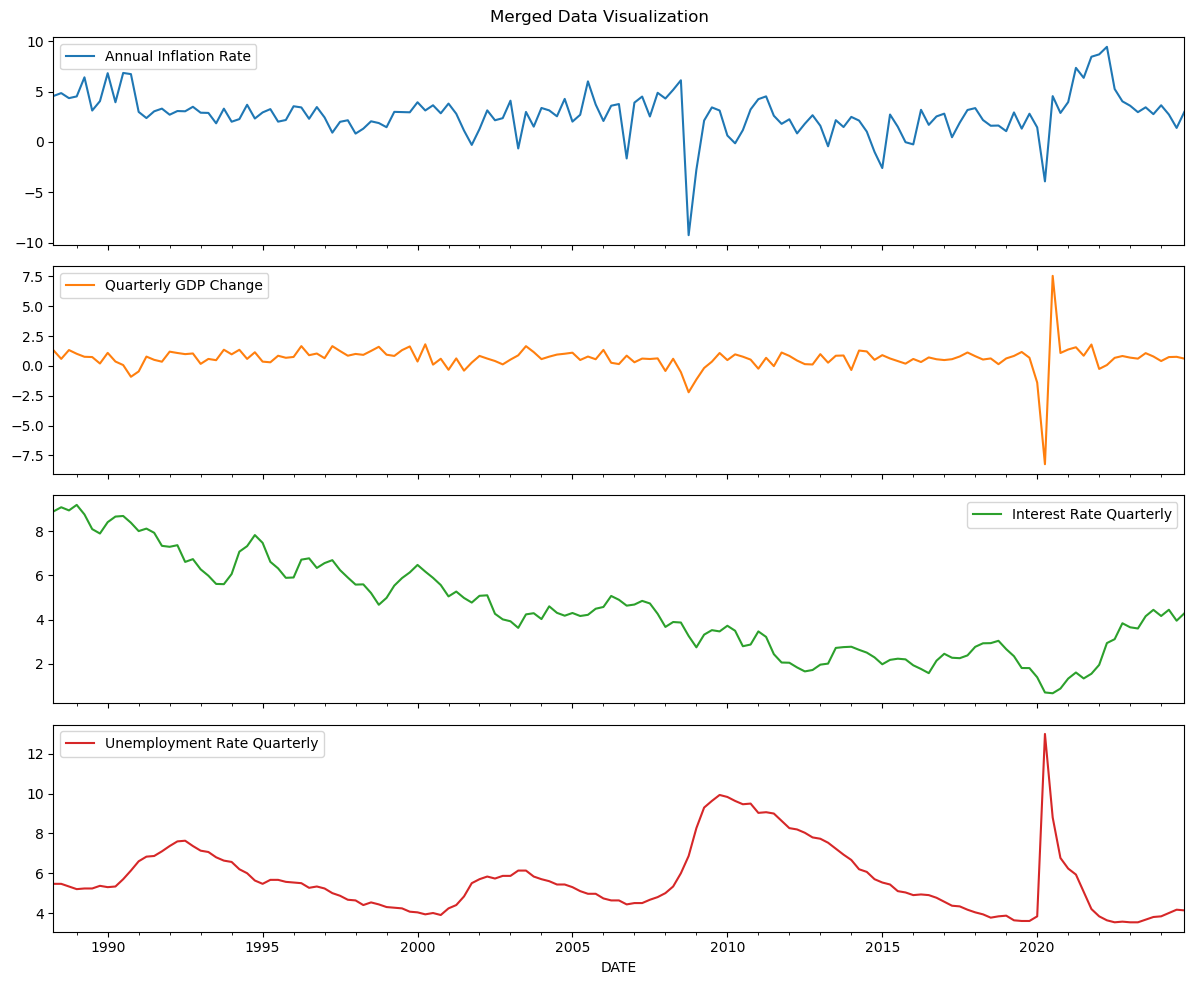

In [398]:
# Download CPI data
df_cpi = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)
df_cpi.dropna(inplace=True)

# Create a column for quarterly CPI using 3-month average (only at quarter-end months)
df_cpi['Quarterly CPI'] = df_cpi['CPIAUCSL'].rolling(window=3).mean()

# Keep only the months that are quarter-ends: March, June, September, December
df_cpi_quarterly = df_cpi[df_cpi.index.month.isin([3, 6, 9, 12])].copy()

# Compute annualized inflation rate
df_cpi_quarterly['Annual Inflation Rate'] = 400 * np.log(
    df_cpi_quarterly['Quarterly CPI'] / df_cpi_quarterly['Quarterly CPI'].shift(1)
)

df_unemp = web.DataReader('UNRATE', 'fred', start_date, end_date)
df_unemp_quarterly = df_unemp.resample('QE').mean()
df_unemp_quarterly.rename(columns={'UNRATE': 'Unemployment Rate Quarterly'}, inplace=True)
df_unemp_quarterly

df_interest = web.DataReader('GS10', 'fred', start_date, end_date)
df_interest_quarterly = df_interest.resample('QE').mean()
df_interest_quarterly.rename(columns={'GS10': 'Interest Rate Quarterly'}, inplace=True)
df_interest_quarterly

df_gdp = web.DataReader('GDPC1', 'fred', start_date, end_date)
# Compute quarterly GDP change (log difference * 100)
df_gdp['Quarterly GDP Change'] = np.log(df_gdp['GDPC1']).diff() * 100
df_gdp.index = pd.to_datetime(df_gdp.index)
# Convert to quarterly period and then get the quarter-end timestamp
df_gdp.index = df_gdp.index.to_period('Q').to_timestamp('Q')
df_gdp.dropna(subset=['Quarterly GDP Change'], inplace=True)
df_gdp

# Ensure all indices are in quarterly frequency and aligned
df_cpi_quarterly.index = df_cpi_quarterly.index.to_period('Q').to_timestamp('Q')
df_gdp.index = df_gdp.index.to_period('Q').to_timestamp('Q')
df_interest_quarterly.index = df_interest_quarterly.index.to_period('Q').to_timestamp('Q')
df_unemp_quarterly.index = df_unemp_quarterly.index.to_period('Q').to_timestamp('Q')

# Merge all DataFrames into a single DataFrame
df_merged = pd.concat([
    df_cpi_quarterly['Annual Inflation Rate'],
    df_gdp['Quarterly GDP Change'],
    df_interest_quarterly['Interest Rate Quarterly'],
    df_unemp_quarterly['Unemployment Rate Quarterly']
], axis=1, join='inner')

# Rename columns for clarity
df_merged.columns = ['Annual Inflation Rate', 'Quarterly GDP Change', 'Interest Rate Quarterly', 'Unemployment Rate Quarterly']

# Drop rows with missing values
df_merged.dropna(inplace=True)

# Display the merged DataFrame
print("Merged DataFrame:")
print(df_merged.head())

# Optionally, plot the merged data to visualize
df_merged.plot(subplots=True, figsize=(12, 10), title="Merged Data Visualization")
plt.tight_layout()
plt.show()

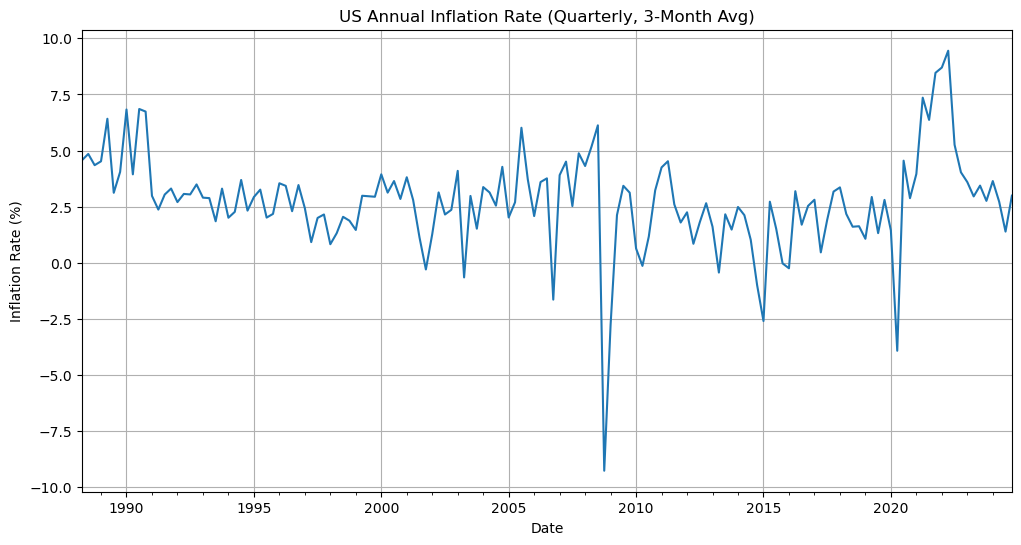

In [399]:
df_inflation = df_cpi_quarterly.dropna()

# Plot
df_inflation['Annual Inflation Rate'].plot(title='US Annual Inflation Rate (Quarterly, 3-Month Avg)', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.grid(True)
plt.show()

In [400]:
display(df_inflation.head())

display(df_inflation.tail())

,CPIAUCSL,Quarterly CPI,Annual Inflation Rate
DATE,,,
1988-06-30,118.0,117.566667,4.562353
1988-09-30,119.5,119.000000,4.847178
1988-12-31,120.7,120.300000,4.346052
1989-03-31,122.2,121.666667,4.518577
1989-06-30,124.1,123.633333,6.414052


,CPIAUCSL,Quarterly CPI,Annual Inflation Rate
DATE,,,
2023-12-31,308.735,308.158333,2.756113
2024-03-31,312.107,310.974333,3.638664
2024-06-30,313.131,313.095667,2.719364
2024-09-30,314.851,314.182667,1.386308
2024-12-31,317.603,316.538667,2.988338


In [401]:
# Extract the Annual Inflation Rate series
inflation_rate_series = df_inflation['Annual Inflation Rate']

# Perform the ADF test
adf_result = adfuller(inflation_rate_series)

# Display the results
adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '# of Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

print("Augmented Dickey-Fuller Test Results:")
display(adf_output)

Augmented Dickey-Fuller Test Results:


Test Statistic                -7.662569e+00
p-value                        1.673539e-11
# of Lags Used                 0.000000e+00
Number of Observations Used    1.460000e+02
Critical Value (1%)           -3.475953e+00
Critical Value (5%)           -2.881548e+00
Critical Value (10%)          -2.577439e+00
dtype: float64

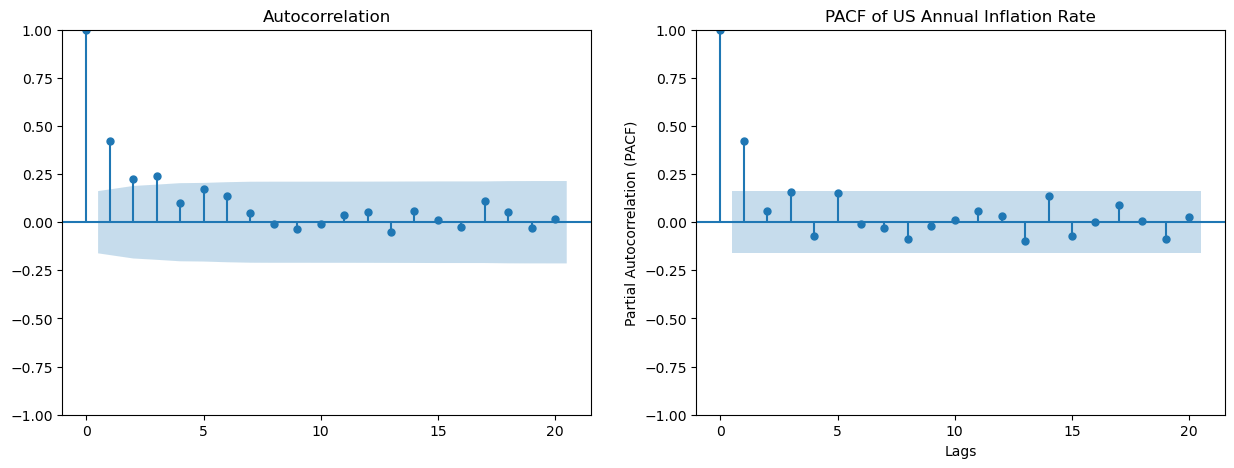

In [402]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot ACF for the annual inflation rate
plot_acf(inflation_rate_series, lags=20, ax=axes[0])
# Plot the PACF for the annual inflation rate
plot_pacf(inflation_rate_series, lags=20, ax=axes[1])
plt.title("PACF of US Annual Inflation Rate")
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation (PACF)')
plt.show()

In [403]:
# Fit an AR(1) model
model_ar1 = AutoReg(df_inflation['Annual Inflation Rate'], lags=1).fit()
print("AR(1) Model Summary:")
display(model_ar1.summary())

# Choose the lag order based on the PACF plot
p = 6

# Fit an AR(p) model
model_arp = AutoReg(df_inflation['Annual Inflation Rate'], lags=p).fit()
print(f"\nAR({p}) Model Summary:")
display(model_arp.summary())

AR(1) Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                              
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(1)   Log Likelihood                -307.163
Method:                  Conditional MLE   S.D. of innovations              1.984
Date:                   Tue, 15 Apr 2025   AIC                            620.326
Time:                           19:57:12   BIC                            629.277
Sample:                       09-30-1988   HQIC                           623.963
                            - 12-31-2024                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.5609      0.262      5.966      0.000       1.048       2.074
Annual Inflation Rate.L1     0.4231      0.075      5.658      0.000       0.277       0.570
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3636           +0.0000j            2.3636            0.0000
-----------------------------------------------------------------------------
"""


AR(6) Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                              
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(6)   Log Likelihood                -293.340
Method:                  Conditional MLE   S.D. of innovations              1.938
Date:                   Tue, 15 Apr 2025   AIC                            602.680
Time:                           19:57:12   BIC                            626.270
Sample:                       12-31-1989   HQIC                           612.266
                            - 12-31-2024                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.1330      0.358      3.166      0.002       0.432       1.834
Annual Inflation Rate.L1     0.4073      0.084      4.842      0.000       0.242       0.572
Annual Inflation Rate.L2    -0.0396      0.089     -0.444      0.657      -0.214       0.135
Annual Inflation Rate.L3     0.1802      0.089      2.034      0.042       0.007       0.354
Annual Inflation Rate.L4    -0.1342      0.089     -1.515      0.130      -0.308       0.039
Annual Inflation Rate.L5     0.1624      0.089      1.819      0.069      -0.013       0.337
Annual Inflation Rate.L6    -0.0085      0.083     -0.102      0.919      -0.172       0.155
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9587           -1.0141j            1.3955           -0.3705
AR.2           -0.9587           +1.0141j            1.3955            0.3705
AR.3            1.2827           -0.0000j            1.2827           -0.0000
AR.4            0.7172           -1.4349j            1.6042           -0.1762
AR.5            0.7172           +1.4349j            1.6042            0.1762
AR.6           18.2680           -0.0000j           18.2680           -0.0000
-----------------------------------------------------------------------------
"""

In [404]:
def calculate_AR_model(df_inflation, lags):

    # Extract the 'Annual Inflation Rate' column
    inflation_rates = df_inflation['Annual Inflation Rate']

    # Fit the AR model
    model = AutoReg(inflation_rates, lags=lags)
    model_fit = model.fit()

    # Print the model summary
    display(model_fit.summary())

    # Get the AR coefficients (excluding the intercept term)
    ar_coef = model_fit.params[1:]

    # Print AR coefficients
    print("\nAR Coefficients:")
    display(ar_coef)

    # Get the residuals
    residuals = model_fit.resid

    # Plot the ACF of residuals
    plt.figure(figsize=(12, 6))
    plot_acf(residuals, lags=12, alpha=0.05)
    plt.title("Autocorrelation Function (ACF) of Residuals")
    plt.show()

    # Perform the Ljung-Box test on residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("Ljung-Box Test Results for Residuals:")
    display(lb_test)

    # Return results
    return model_fit, ar_coef, lb_test, residuals


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                              
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(1)   Log Likelihood                -307.163
Method:                  Conditional MLE   S.D. of innovations              1.984
Date:                   Tue, 15 Apr 2025   AIC                            620.326
Time:                           19:57:12   BIC                            629.277
Sample:                       09-30-1988   HQIC                           623.963
                            - 12-31-2024                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.5609      0.262      5.966      0.000       1.048       2.074
Annual Inflation Rate.L1     0.4231      0.075      5.658      0.000       0.277       0.570
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3636           +0.0000j            2.3636            0.0000
-----------------------------------------------------------------------------
"""


AR Coefficients:


Annual Inflation Rate.L1    0.423087
dtype: float64

<Figure size 1200x600 with 0 Axes>

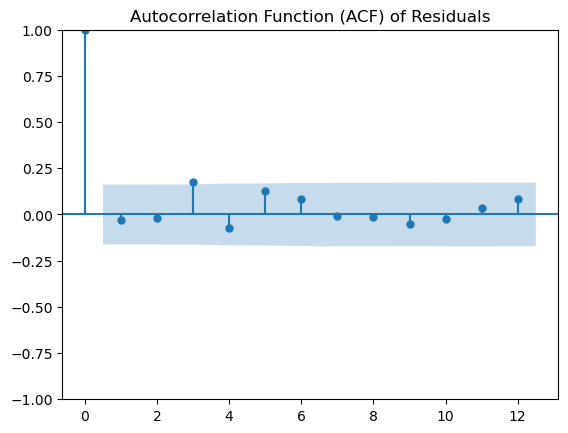

Ljung-Box Test Results for Residuals:


,lb_stat,lb_pvalue
10,9.725454,0.464901


In [405]:
model_fit, ar_coef, lb_test, residuals = calculate_AR_model(df_inflation, lags=1)

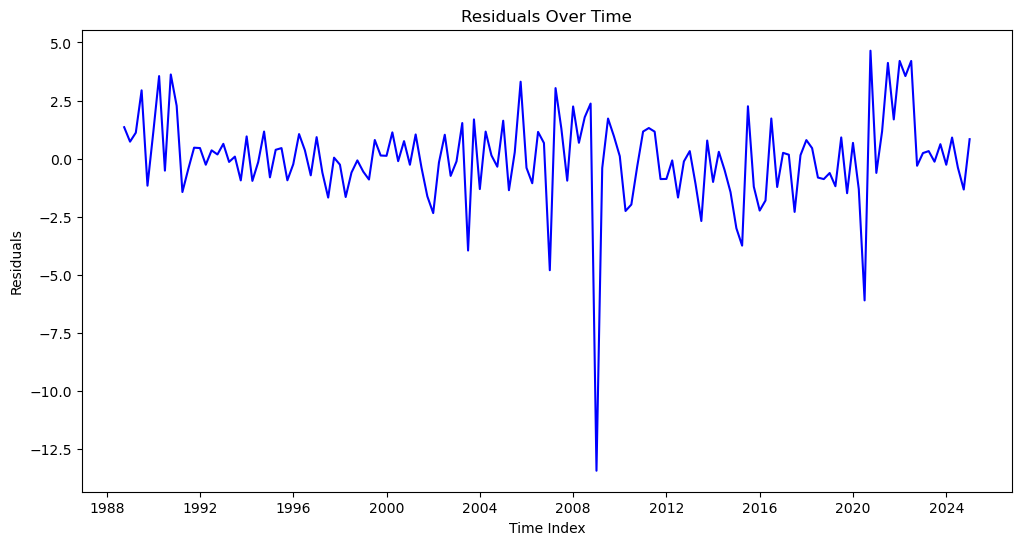

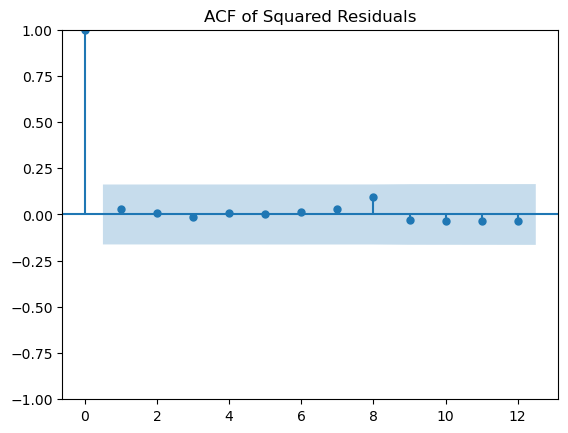

ARCH Test Results:
LM Statistic      1.818706
p-value           0.997550
F-statistic       0.169426
F-test p-value    0.997991
dtype: float64


In [406]:
# Plot the residuals to visually inspect for volatility clustering
plt.figure(figsize=(12, 6))
plt.plot(residuals, color='blue')
plt.title('Residuals Over Time')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.show()

# Plot the ACF of squared residuals (common way to detect ARCH effects)
plot_acf(residuals ** 2, lags=12, alpha = 0.05)
plt.title('ACF of Squared Residuals')
plt.show()

# Perform the ARCH-LM Test
arch_test = het_arch(residuals)
arch_test_results = pd.Series(arch_test, index=['LM Statistic', 'p-value', 'F-statistic', 'F-test p-value'])

print("ARCH Test Results:")
print(arch_test_results)


In [407]:
results = []
for i in range(1, 13):  # AR models from lag 1 to 12

    model = AutoReg(inflation_rate_series, lags=i)
    model_fit = model.fit()
    aic = model_fit.aic
    bic = model_fit.bic
    results.append([i, aic, bic])
    print(f"AR({i}): AIC={aic:.2f}, BIC={bic:.2f}")

# Find the best models based on AIC and BIC
results_df = pd.DataFrame(results, columns=['Lag', 'AIC', 'BIC'])
best_aic_model = results_df.loc[results_df['AIC'].idxmin()]  # Find row with minimum AIC
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]  # Find row with minimum BIC


print(f"\nBest Model (AIC): Lag {int(best_aic_model['Lag'])}, AIC={best_aic_model['AIC']:.2f}, BIC={best_aic_model['BIC']:.2f}")
print(f"Best Model (BIC): Lag {int(best_bic_model['Lag'])}, AIC={best_bic_model['AIC']:.2f}, BIC={best_bic_model['BIC']:.2f}")

AR(1): AIC=620.33, BIC=629.28
AR(2): AIC=618.15, BIC=630.05
AR(3): AIC=613.18, BIC=628.03
AR(4): AIC=611.09, BIC=628.87
AR(5): AIC=604.28, BIC=624.97
AR(6): AIC=602.68, BIC=626.27
AR(7): AIC=601.19, BIC=627.66
AR(8): AIC=596.67, BIC=626.01
AR(9): AIC=595.46, BIC=627.66
AR(10): AIC=591.30, BIC=626.34
AR(11): AIC=588.37, BIC=626.23
AR(12): AIC=586.82, BIC=627.50

Best Model (AIC): Lag 12, AIC=586.82, BIC=627.50
Best Model (BIC): Lag 5, AIC=604.28, BIC=624.97


In [408]:
# Define Train and Validation Sets Using Boolean Indexing
train_data = df_inflation.loc[df_inflation.index < '2017-01-01']
validation_data = df_inflation.loc[(df_inflation.index >= '2017-01-01') & (df_inflation.index < '2020-03-01')]
test_data = df_inflation.loc[df_inflation.index >= '2020-03-01']

In [409]:
# Fit an AR(1) model
model_ar1 = AutoReg(train_data['Annual Inflation Rate'], lags=1).fit()
print("\nAR(1) Model Summary:")
display(model_ar1.summary())

model_ar3 = AutoReg(train_data['Annual Inflation Rate'], lags=3).fit()
print("\nAR(3) Model Summary:")
display(model_ar3.summary())

model_ar6 = AutoReg(train_data['Annual Inflation Rate'], lags=6).fit()
print("\nAR(6) Model Summary:")
display(model_ar6.summary())

model_ar9 = AutoReg(train_data['Annual Inflation Rate'], lags=9).fit()
print("\nAR(9) Model Summary:")
display(model_ar9.summary())

model_ar12 = AutoReg(train_data['Annual Inflation Rate'], lags=12).fit()
print("\nAR(12) Model Summary:")
display(model_ar12.summary())



AR(1) Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                              
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  115
Model:                        AutoReg(1)   Log Likelihood                -236.288
Method:                  Conditional MLE   S.D. of innovations              1.923
Date:                   Tue, 15 Apr 2025   AIC                            478.576
Time:                           19:57:13   BIC                            486.785
Sample:                       09-30-1988   HQIC                           481.907
                            - 12-31-2016                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.7090      0.288      5.928      0.000       1.144       2.274
Annual Inflation Rate.L1     0.3236      0.088      3.669      0.000       0.151       0.496
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.0904           +0.0000j            3.0904            0.0000
-----------------------------------------------------------------------------
"""


AR(3) Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                              
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  115
Model:                        AutoReg(3)   Log Likelihood                -231.402
Method:                  Conditional MLE   S.D. of innovations              1.910
Date:                   Tue, 15 Apr 2025   AIC                            472.804
Time:                           19:57:13   BIC                            486.396
Sample:                       03-31-1989   HQIC                           478.319
                            - 12-31-2016                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.5359      0.368      4.171      0.000       0.814       2.258
Annual Inflation Rate.L1     0.3283      0.093      3.514      0.000       0.145       0.511
Annual Inflation Rate.L2    -0.0857      0.098     -0.874      0.382      -0.278       0.107
Annual Inflation Rate.L3     0.1389      0.093      1.496      0.135      -0.043       0.321
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7059           -0.0000j            1.7059           -0.0000
AR.2           -0.5443           -1.9810j            2.0544           -0.2927
AR.3           -0.5443           +1.9810j            2.0544            0.2927
-----------------------------------------------------------------------------
"""


AR(6) Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                              
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  115
Model:                        AutoReg(6)   Log Likelihood                -222.591
Method:                  Conditional MLE   S.D. of innovations              1.865
Date:                   Tue, 15 Apr 2025   AIC                            461.182
Time:                           19:57:13   BIC                            482.713
Sample:                       12-31-1989   HQIC                           469.914
                            - 12-31-2016                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.2087      0.441      2.744      0.006       0.345       2.072
Annual Inflation Rate.L1     0.3102      0.095      3.252      0.001       0.123       0.497
Annual Inflation Rate.L2    -0.1161      0.098     -1.189      0.234      -0.307       0.075
Annual Inflation Rate.L3     0.1344      0.098      1.365      0.172      -0.059       0.327
Annual Inflation Rate.L4    -0.0823      0.099     -0.832      0.405      -0.276       0.111
Annual Inflation Rate.L5     0.1534      0.099      1.554      0.120      -0.040       0.347
Annual Inflation Rate.L6     0.0906      0.095      0.958      0.338      -0.095       0.276
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2260           -0.0000j            1.2260           -0.0000
AR.2            0.6288           -1.1754j            1.3330           -0.1718
AR.3            0.6288           +1.1754j            1.3330            0.1718
AR.4           -0.8169           -1.1511j            1.4115           -0.3482
AR.5           -0.8169           +1.1511j            1.4115            0.3482
AR.6           -2.5432           -0.0000j            2.5432           -0.5000
-----------------------------------------------------------------------------
"""


AR(9) Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                              
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  115
Model:                        AutoReg(9)   Log Likelihood                -215.932
Method:                  Conditional MLE   S.D. of innovations              1.855
Date:                   Tue, 15 Apr 2025   AIC                            453.864
Time:                           19:57:13   BIC                            483.161
Sample:                       09-30-1990   HQIC                           465.738
                            - 12-31-2016                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        1.3324      0.502      2.654      0.008       0.348       2.316
Annual Inflation Rate.L1     0.2995      0.097      3.084      0.002       0.109       0.490
Annual Inflation Rate.L2    -0.1231      0.100     -1.231      0.218      -0.319       0.073
Annual Inflation Rate.L3     0.0999      0.102      0.981      0.326      -0.100       0.299
Annual Inflation Rate.L4    -0.0762      0.103     -0.742      0.458      -0.278       0.125
Annual Inflation Rate.L5     0.1295      0.101      1.288      0.198      -0.068       0.327
Annual Inflation Rate.L6     0.0873      0.101      0.864      0.388      -0.111       0.285
Annual Inflation Rate.L7    -0.0146      0.101     -0.145      0.885      -0.213       0.184
Annual Inflation Rate.L8     0.0685      0.103      0.662      0.508      -0.134       0.271
Annual Inflation Rate.L9    -0.0477      0.099     -0.482      0.630      -0.241       0.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4102           -0.0000j            1.4102           -0.5000
AR.2           -0.8400           -0.9382j            1.2593           -0.3662
AR.3           -0.8400           +0.9382j            1.2593            0.3662
AR.4           -0.0723           -1.4916j            1.4933           -0.2577
AR.5           -0.0723           +1.4916j            1.4933            0.2577
AR.6            0.7021           -1.0766j            1.2853           -0.1580
AR.7            0.7021           +1.0766j            1.2853            0.1580
AR.8            1.2845           -0.0000j            1.2845           -0.0000
AR.9            1.9832           -0.0000j            1.9832           -0.0000
-----------------------------------------------------------------------------
"""


AR(12) Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                              AutoReg Model Results                              
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  115
Model:                       AutoReg(12)   Log Likelihood                -207.391
Method:                  Conditional MLE   S.D. of innovations              1.812
Date:                   Tue, 15 Apr 2025   AIC                            442.782
Time:                           19:57:13   BIC                            479.668
Sample:                       06-30-1991   HQIC                           457.722
                            - 12-31-2016                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.4997      0.574      2.614      0.009       0.375       2.624
Annual Inflation Rate.L1      0.2601      0.098      2.644      0.008       0.067       0.453
Annual Inflation Rate.L2     -0.1504      0.101     -1.494      0.135      -0.348       0.047
Annual Inflation Rate.L3      0.0673      0.101      0.664      0.507      -0.132       0.266
Annual Inflation Rate.L4     -0.0760      0.102     -0.742      0.458      -0.277       0.125
Annual Inflation Rate.L5      0.0872      0.101      0.863      0.388      -0.111       0.285
Annual Inflation Rate.L6      0.0523      0.102      0.515      0.607      -0.147       0.252
Annual Inflation Rate.L7     -0.0293      0.102     -0.287      0.774      -0.230       0.171
Annual Inflation Rate.L8      0.0603      0.103      0.584      0.559      -0.142       0.263
Annual Inflation Rate.L9     -0.0750      0.103     -0.727      0.467      -0.277       0.127
Annual Inflation Rate.L10     0.0115      0.102      0.112      0.911      -0.189       0.212
Annual Inflation Rate.L11     0.0469      0.102      0.460      0.645      -0.153       0.246
Annual Inflation Rate.L12     0.0619      0.097      0.638      0.523      -0.128       0.252
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.1796           -0.0000j            1.1796           -0.0000
AR.2             1.0675           -0.6133j            1.2312           -0.0830
AR.3             1.0675           +0.6133j            1.2312            0.0830
AR.4             0.5645           -1.0036j            1.1515           -0.1684
AR.5             0.5645           +1.0036j            1.1515            0.1684
AR.6            -0.0435           -1.2264j            1.2272           -0.2556
AR.7            -0.0435           +1.2264j            1.2272            0.2556
AR.8            -1.2859           -0.0000j            1.2859           -0.5000
AR.9            -0.7846           -1.0278j            1.2930           -0.3538
AR.10           -0.7846           +1.0278j            1.2930            0.3538
AR.11           -1.1293           -0.9101j            1.4503           -0.3920
AR.12           -1.1293           +0.9101j            1.4503            0.3920
------------------------------------------------------------------------------
"""

In [410]:
for p in range(1,13):
    model = AutoReg(train_data['Annual Inflation Rate'], lags=p).fit()
    predictions = model.predict(start=validation_data.index[0], end=validation_data.index[-1])
    mse = mean_squared_error(validation_data['Annual Inflation Rate'], predictions)
    print(f"AR({p}) Validation MSE: {mse:.4f}")

AR(1) Validation MSE: 0.9540
AR(2) Validation MSE: 0.9403
AR(3) Validation MSE: 0.8887
AR(4) Validation MSE: 0.8777
AR(5) Validation MSE: 0.6879
AR(6) Validation MSE: 0.6160
AR(7) Validation MSE: 0.6159
AR(8) Validation MSE: 0.6793
AR(9) Validation MSE: 0.7322
AR(10) Validation MSE: 0.7126
AR(11) Validation MSE: 0.7831
AR(12) Validation MSE: 0.8531


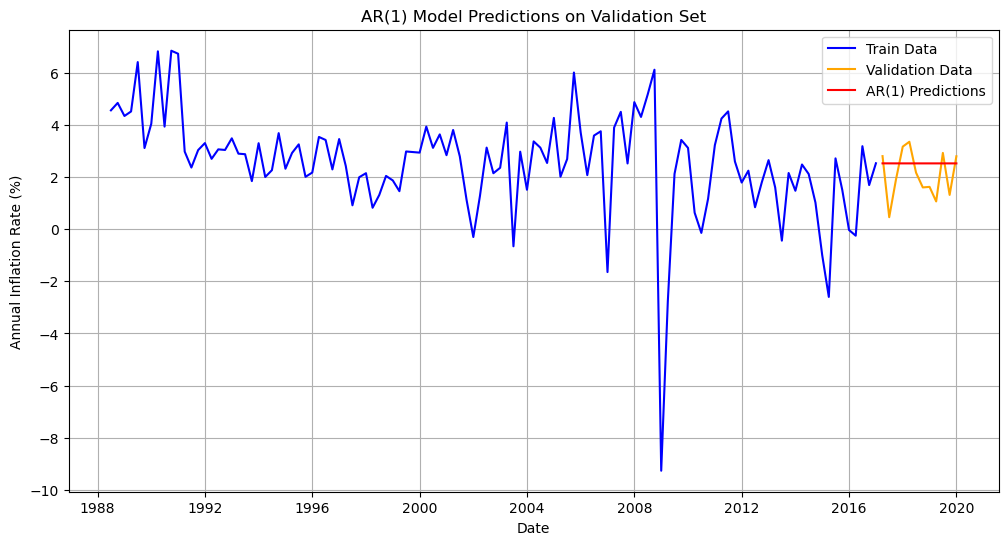

In [411]:
# Plot the predictions for AR(1) model
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Train Data', color='blue')
plt.plot(validation_data.index, validation_data['Annual Inflation Rate'], label='Validation Data', color='orange')
plt.plot(validation_data.index, model_ar1.predict(start=validation_data.index[0], end=validation_data.index[-1]), label='AR(1) Predictions', color='red')
plt.title('AR(1) Model Predictions on Validation Set')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

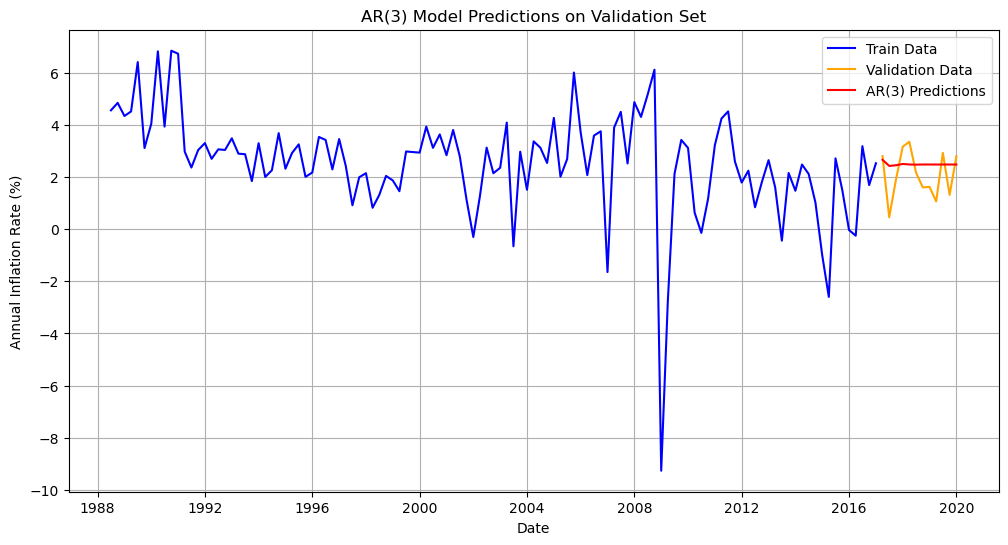

In [412]:
# Plot the predictions for AR(3) model
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Train Data', color='blue')
plt.plot(validation_data.index, validation_data['Annual Inflation Rate'], label='Validation Data', color='orange')
plt.plot(validation_data.index, model_ar3.predict(start=validation_data.index[0], end=validation_data.index[-1]), label='AR(3) Predictions', color='red')
plt.title('AR(3) Model Predictions on Validation Set')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

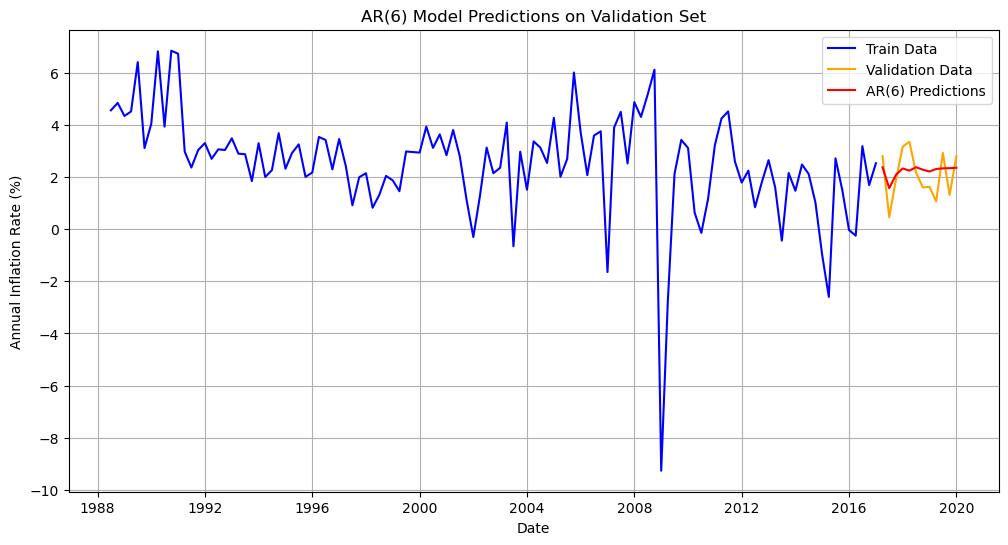

In [413]:
# Plot the predictions for AR(6) model
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Train Data', color='blue')
plt.plot(validation_data.index, validation_data['Annual Inflation Rate'], label='Validation Data', color='orange')
plt.plot(validation_data.index, model_ar6.predict(start=validation_data.index[0], end=validation_data.index[-1]), label='AR(6) Predictions', color='red')
plt.title('AR(6) Model Predictions on Validation Set')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


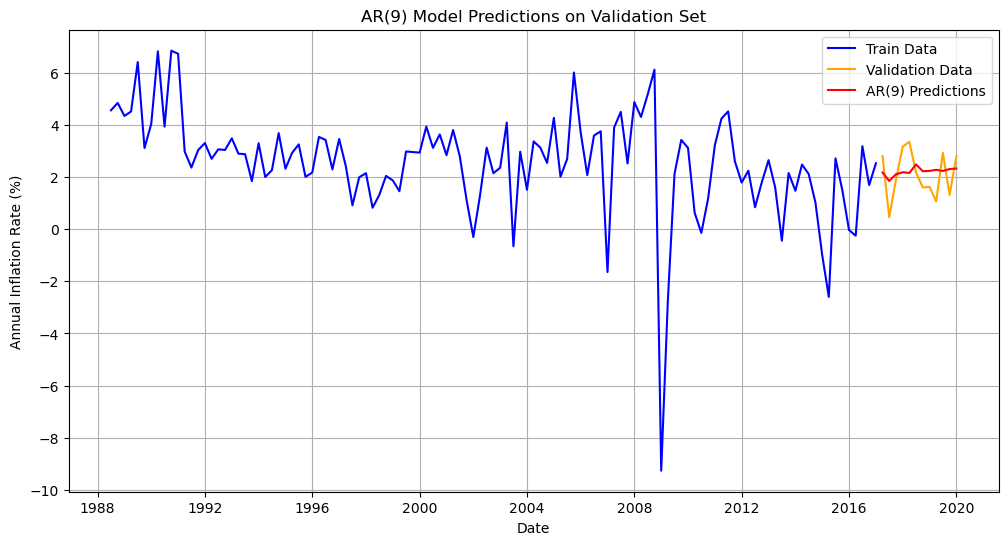

In [414]:
# Plot the predictions for AR(9) model
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Train Data', color='blue')
plt.plot(validation_data.index, validation_data['Annual Inflation Rate'], label='Validation Data', color='orange')
plt.plot(validation_data.index, model_ar9.predict(start=validation_data.index[0], end=validation_data.index[-1]), label='AR(9) Predictions', color='red')
plt.title('AR(9) Model Predictions on Validation Set')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()


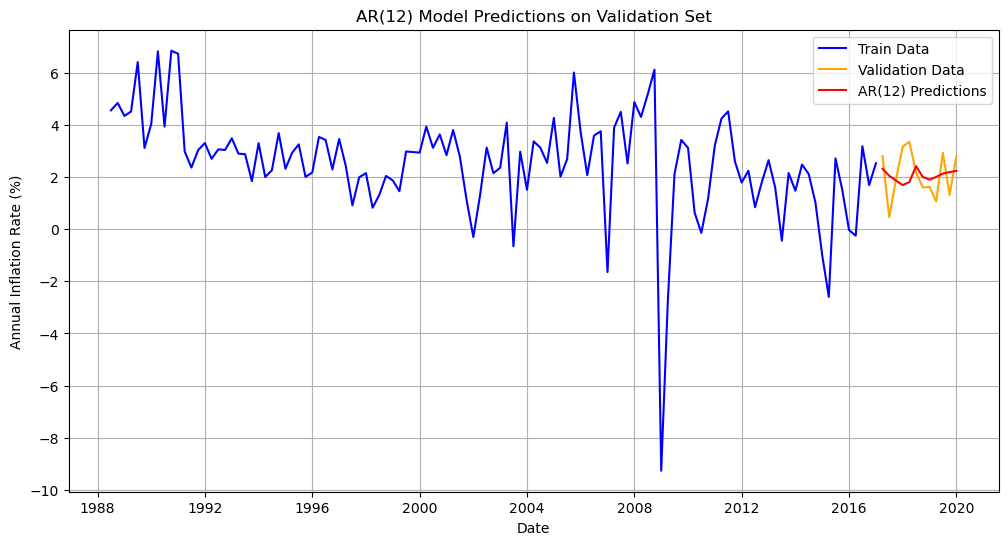

In [415]:
# Plot the predictions for AR(12) model

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Annual Inflation Rate'], label='Train Data', color='blue')
plt.plot(validation_data.index, validation_data['Annual Inflation Rate'], label='Validation Data', color='orange')
plt.plot(validation_data.index, model_ar12.predict(start=validation_data.index[0], end=validation_data.index[-1]), label='AR(12) Predictions', color='red')
plt.title('AR(12) Model Predictions on Validation Set')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [416]:
n = 50
predictions = pd.DataFrame(index=df_inflation.index, columns=range(1, 13))
rmse = {}


for p in range(1, 13):
    
    rmse[p] = 0
    
    for index in range(n, len(df_inflation)):  # Ensure the range covers all valid indices
    
        # Train the model on data up to the current index
        model = AutoReg(df_inflation['Annual Inflation Rate'][:index-1], lags=p).fit()
        # Predict the next time step (index)
        predictions[p][index] = model.predict(start=index, end=index).values[0]
        
    rmse[p] = np.sqrt(mean_squared_error(df_inflation['Annual Inflation Rate'][n:], predictions[p][n:]))

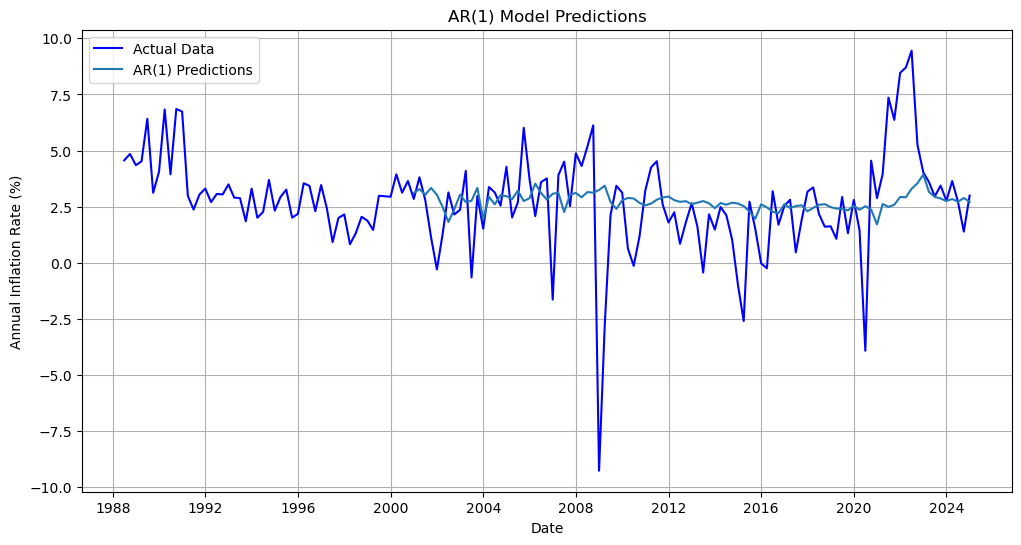

In [417]:
# Plot the predictions for AR(1) model
plt.figure(figsize=(12, 6))
plt.plot(df_inflation.index, df_inflation['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions.index, predictions[1], label=f'AR(1) Predictions')
plt.title('AR(1) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

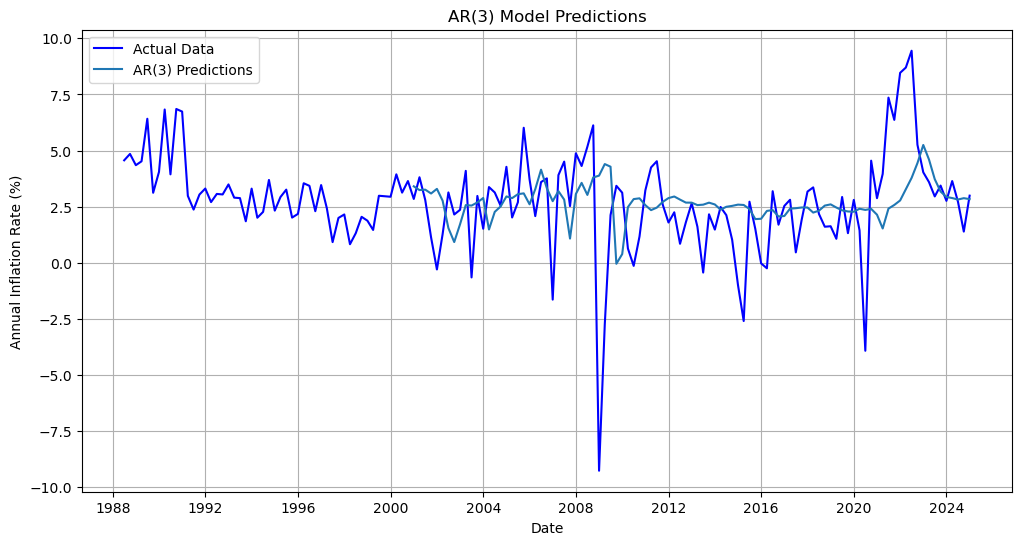

In [418]:
# Plot the predictions for AR(3) model
plt.figure(figsize=(12, 6))
plt.plot(df_inflation.index, df_inflation['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions.index, predictions[3], label=f'AR(3) Predictions')
plt.title('AR(3) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

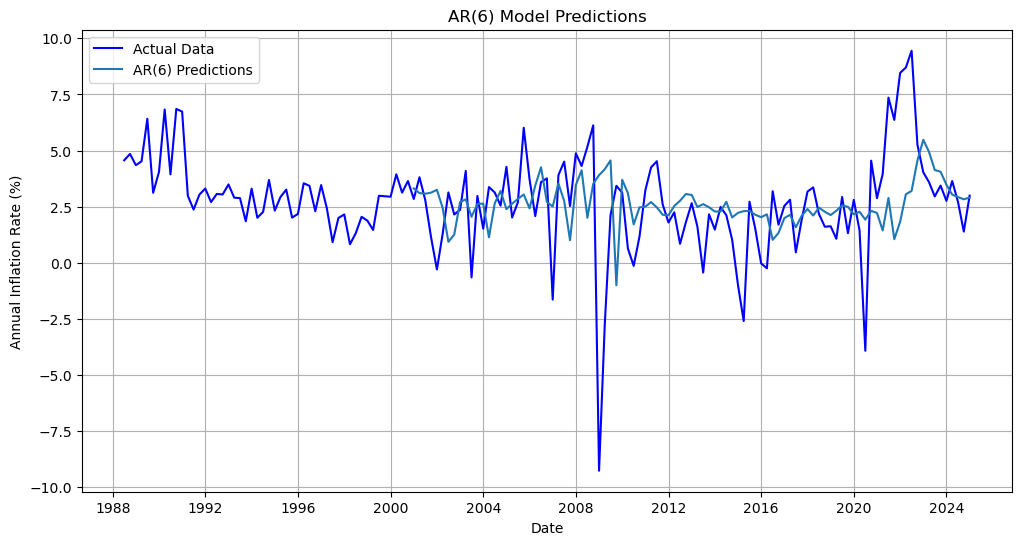

In [419]:
# plot the predictions for AR(6) model
plt.figure(figsize=(12, 6))
plt.plot(df_inflation.index, df_inflation['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions.index, predictions[6], label=f'AR(6) Predictions')
plt.title('AR(6) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

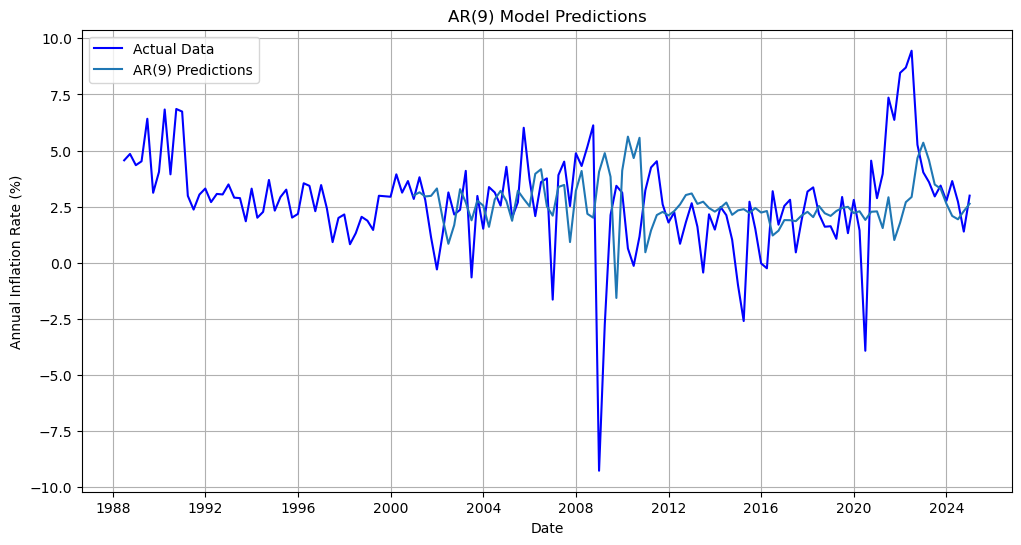

In [420]:
# plot the predictions for AR(9) model
plt.figure(figsize=(12, 6))
plt.plot(df_inflation.index, df_inflation['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions.index, predictions[9], label=f'AR(9) Predictions')
plt.title('AR(9) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

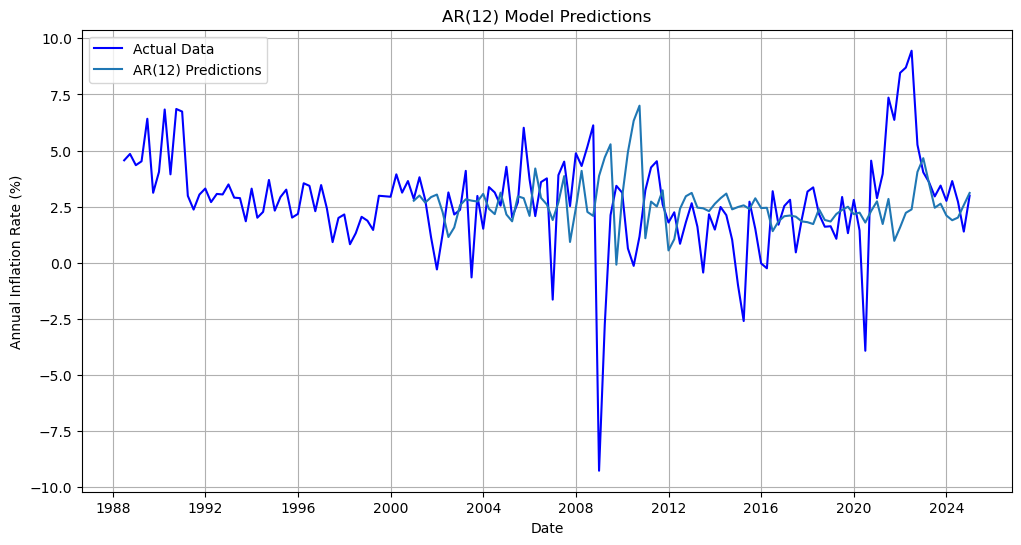

In [421]:
# Plot the predictions for AR(12) model
plt.figure(figsize=(12, 6))
plt.plot(df_inflation.index, df_inflation['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions.index, predictions[12], label=f'AR(12) Predictions')
plt.title('AR(12) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [422]:
# Print the RMSE values for each model

for p in range(1, 13):
    print(f"AR({p}) RMSE: {np.sqrt(mean_squared_error(df_inflation['Annual Inflation Rate'][n:], predictions[p][n:])):.4f}")

AR(1) RMSE: 2.4905
AR(2) RMSE: 2.5309
AR(3) RMSE: 2.5721
AR(4) RMSE: 2.6137
AR(5) RMSE: 2.5828
AR(6) RMSE: 2.6098
AR(7) RMSE: 2.6247
AR(8) RMSE: 2.7877
AR(9) RMSE: 2.8025
AR(10) RMSE: 2.8239
AR(11) RMSE: 2.8328
AR(12) RMSE: 2.8613


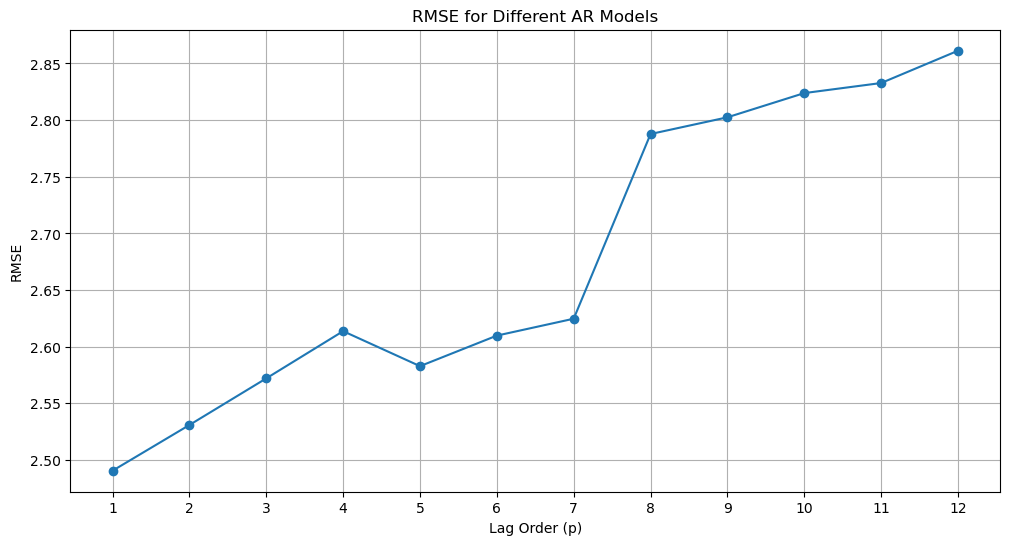

In [423]:
# Plot the RMSE values for each model
plt.figure(figsize=(12, 6))
plt.plot(range(1, 13), list(rmse.values()), marker='o')  # Extract values from the rmse dictionary
plt.title('RMSE for Different AR Models')
plt.xlabel('Lag Order (p)')
plt.ylabel('RMSE')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

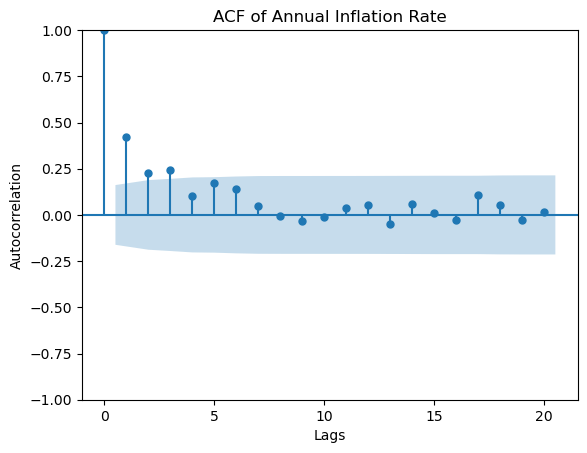

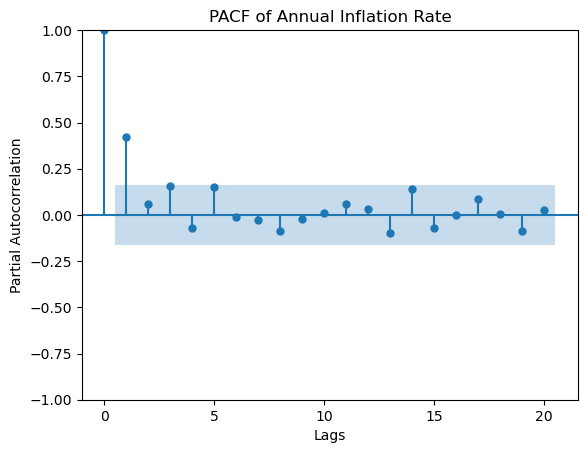

In [424]:
# Predict using ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Check best ARIMA parameters using ACF and PACF plots
plot_acf(df_inflation['Annual Inflation Rate'], lags=20)
plt.title('ACF of Annual Inflation Rate')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

plot_pacf(df_inflation['Annual Inflation Rate'], lags=20)
plt.title('PACF of Annual Inflation Rate')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()


ARIMA(2, 0, 4) Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                    ARIMA(2, 0, 4)   Log Likelihood                -305.802
Date:                   Tue, 15 Apr 2025   AIC                            627.604
Time:                           19:57:28   BIC                            651.528
Sample:                       06-30-1988   HQIC                           637.325
                            - 12-31-2024                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7658      0.509      5.431      0.000       1.768       3.764
ar.L1          0.5050      0.919      0.549      0.583      -1.297       2.307
ar.L2          0.2727      0.539      0.506      0.613      -0.783       1.329
ma.L1         -0.0901      0.915     -0.098      0.922      -1.884       1.704
ma.L2         -0.3389      0.314     -1.081      0.280      -0.953       0.276
ma.L3          0.0469      0.164      0.286      0.775      -0.274       0.368
ma.L4         -0.0900      0.221     -0.408      0.684      -0.523       0.343
sigma2         3.7446      0.207     18.125      0.000       3.340       4.150
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1509.45
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.24   Skew:                            -2.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

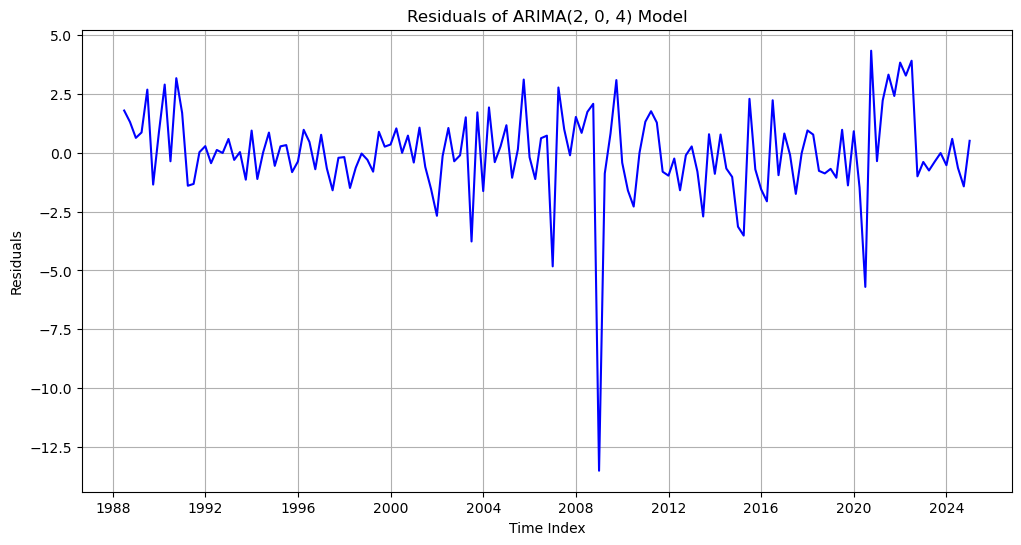

In [425]:
# Fit ARIMA(2, 0, 4) model
model_arima = ARIMA(df_inflation['Annual Inflation Rate'], order=(2, 0, 4)).fit()
print("\nARIMA(2, 0, 4) Model Summary:")
display(model_arima.summary())

# Plot the residuals of the ARIMA model
plt.figure(figsize=(12, 6))
plt.plot(model_arima.resid, color='blue')
plt.title('Residuals of ARIMA(2, 0, 4) Model')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

ARIMA(2, 0, 4) RMSE: 2.5870


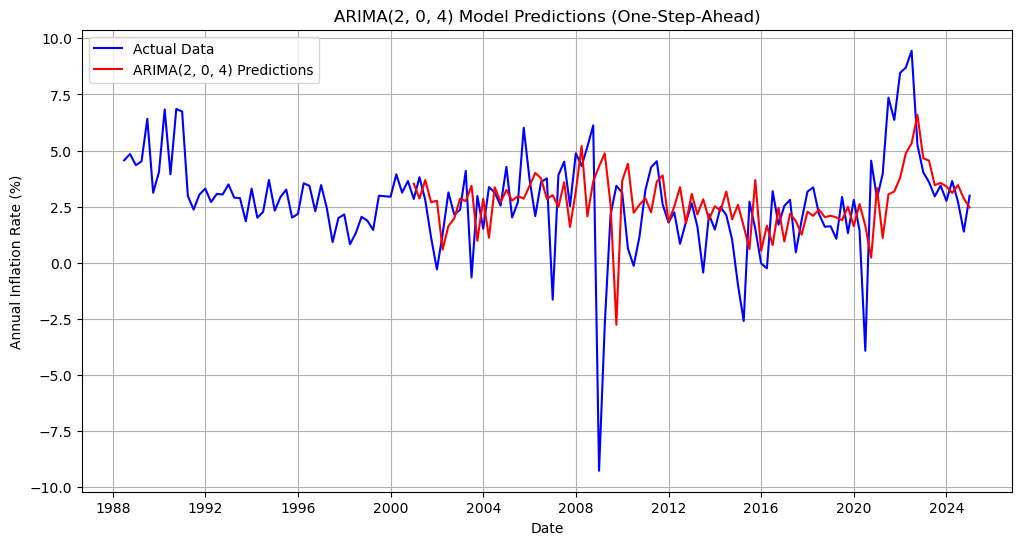

In [426]:

predictions_arima = pd.Series(index=df_inflation.index, dtype=float)
rolling_window = 50  # Define the rolling window size
rmse_arima = []

for i in range(rolling_window, len(df_inflation)):
    # Train the ARIMA model on data up to the current time step (excluding the current value)
    model = ARIMA(df_inflation['Annual Inflation Rate'][:i], order=(2, 0, 4)).fit()
    # Predict the next time step (i)
    predictions_arima.iloc[i] = model.forecast(steps=1)[0]
    
# Calculate RMSE for whole series
rmse_arima = np.sqrt(mean_squared_error(df_inflation['Annual Inflation Rate'][rolling_window:], predictions_arima[rolling_window:]))
print(f"ARIMA(2, 0, 4) RMSE: {rmse_arima:.4f}")

# Plot the corrected predictions
plt.figure(figsize=(12, 6))
plt.plot(df_inflation.index, df_inflation['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions_arima.index, predictions_arima, label='ARIMA(2, 0, 4) Predictions', color='red')
plt.title('ARIMA(2, 0, 4) Model Predictions (One-Step-Ahead)')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

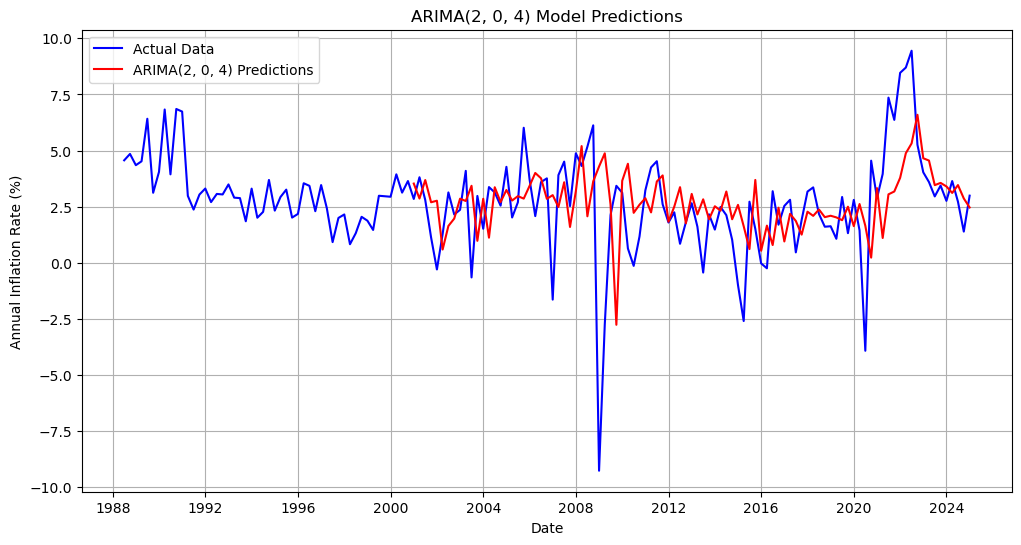

In [427]:
# Plot the predictions from the ARIMA model
plt.figure(figsize=(12, 6))
plt.plot(df_inflation.index, df_inflation['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(predictions_arima.index, predictions_arima, label='ARIMA(2, 0, 4) Predictions', color='red')
plt.title('ARIMA(2, 0, 4) Model Predictions')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

In [462]:
# Fit ARDL model with exogs
exog = df_merged[['Quarterly GDP Change', 'Interest Rate Quarterly', 'Unemployment Rate Quarterly']]

# Initialize variables to store the best model
best_aic = np.inf
best_bic = np.inf
best_lag = None
best_order = None

for p in range(1, 13):
    for q in range(1, 13):
        model_ardl = ARDL(df_merged['Annual Inflation Rate'], lags=p, exog=exog, order = q ).fit()
        
        if model_ardl.aic < best_aic:
            best_aic = model_ardl.aic
            best_order = (p, q)
            best_model = model_ardl
        
        if model_ardl.bic < best_bic:
            best_bic = model_ardl.bic
            best_lag = (p, q)
            best_model_bic = model_ardl

# Print the best ARDL model based on AIC and BIC
print(f"Best ARDL Model (AIC): Lag Order {best_order}, AIC={best_aic:.2f}")
display(best_model.summary())
print(f"Best ARDL Model (BIC): Lag Order {best_lag}, BIC={best_bic:.2f}")
display(best_model_bic.summary())
        
    

Best ARDL Model (AIC): Lag Order (12, 1), AIC=566.71


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARDL Model Results                               
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                 ARDL(12, 1, 1, 1)   Log Likelihood                -263.354
Method:                  Conditional MLE   S.D. of innovations              1.702
Date:                   Tue, 15 Apr 2025   AIC                            566.707
Time:                           20:35:21   BIC                            624.813
Sample:                       06-30-1991   HQIC                           590.319
                            - 12-31-2024                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              1.2018      0.896      1.342      0.182      -0.572       2.976
Annual Inflation Rate.L1           0.3600      0.091      3.976      0.000       0.181       0.539
Annual Inflation Rate.L2          -0.0021      0.091     -0.024      0.981      -0.183       0.178
Annual Inflation Rate.L3           0.1383      0.089      1.556      0.122      -0.038       0.314
Annual Inflation Rate.L4          -0.0487      0.090     -0.539      0.591      -0.227       0.130
Annual Inflation Rate.L5           0.0788      0.091      0.869      0.386      -0.101       0.258
Annual Inflation Rate.L6           0.0058      0.091      0.063      0.950      -0.175       0.187
Annual Inflation Rate.L7          -0.0186      0.090     -0.206      0.837      -0.198       0.160
Annual Inflation Rate.L8          -0.0463      0.090     -0.513      0.609      -0.225       0.133
Annual Inflation Rate.L9          -0.0429      0.089     -0.482      0.631      -0.219       0.133
Annual Inflation Rate.L10          0.0236      0.087      0.272      0.786      -0.148       0.195
Annual Inflation Rate.L11          0.0146      0.089      0.165      0.870      -0.161       0.190
Annual Inflation Rate.L12          0.0669      0.087      0.771      0.442      -0.105       0.239
Quarterly GDP Change.L0            0.6510      0.358      1.818      0.072      -0.058       1.360
Quarterly GDP Change.L1            0.0686      0.181      0.380      0.705      -0.289       0.427
Interest Rate Quarterly.L0         1.1336      0.484      2.343      0.021       0.175       2.092
Interest Rate Quarterly.L1        -1.1895      0.463     -2.570      0.011      -2.106      -0.273
Unemployment Rate Quarterly.L0     0.0273      0.420      0.065      0.948      -0.804       0.858
Unemployment Rate Quarterly.L1    -0.0650      0.413     -0.158      0.875      -0.883       0.752
==================================================================================================
"""

Best ARDL Model (BIC): Lag Order (5, 1), BIC=623.13


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARDL Model Results                               
=================================================================================
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                  ARDL(5, 1, 1, 1)   Log Likelihood                -279.351
Method:                  Conditional MLE   S.D. of innovations              1.730
Date:                   Tue, 15 Apr 2025   AIC                            584.703
Time:                           20:35:21   BIC                            623.128
Sample:                       09-30-1989   HQIC                           600.317
                            - 12-31-2024                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.9381      0.853      1.100      0.273      -0.749       2.626
Annual Inflation Rate.L1           0.3762      0.085      4.430      0.000       0.208       0.544
Annual Inflation Rate.L2          -0.0043      0.086     -0.050      0.960      -0.175       0.166
Annual Inflation Rate.L3           0.1524      0.083      1.841      0.068      -0.011       0.316
Annual Inflation Rate.L4          -0.0861      0.084     -1.020      0.310      -0.253       0.081
Annual Inflation Rate.L5           0.0928      0.080      1.160      0.248      -0.065       0.251
Quarterly GDP Change.L0            0.3350      0.318      1.053      0.294      -0.294       0.964
Quarterly GDP Change.L1           -0.0304      0.167     -0.182      0.856      -0.361       0.300
Interest Rate Quarterly.L0         1.3927      0.442      3.154      0.002       0.519       2.266
Interest Rate Quarterly.L1        -1.3400      0.426     -3.148      0.002      -2.182      -0.498
Unemployment Rate Quarterly.L0    -0.2807      0.383     -0.733      0.465      -1.038       0.477
Unemployment Rate Quarterly.L1     0.2652      0.374      0.710      0.479      -0.474       1.005
==================================================================================================
"""

In [468]:
# Do a rolling prediction on the best ARDL (12, 1) model 

rolling_predictions_ardl = pd.Series(index=df_merged.index, dtype=float)
rolling_window = 50  # Define the rolling window size
rmse_ardl = []

for i in range(rolling_window, len(df_merged)):
    # Train the ARDL model on data up to the current time step (excluding the current value)
    model = ARDL(df_merged['Annual Inflation Rate'][:i], lags=best_order[0], exog=exog[:i]).fit()
    # Predict the next time step (i)
    rolling_predictions_ardl.iloc[i] = model.predict(start=i, end=i, exog=exog.iloc[:i], exog_oos=exog.iloc[[i]])[0]
    
# Calculate RMSE for whole series
rmse_ardl = np.sqrt(mean_squared_error(df_merged['Annual Inflation Rate'][rolling_window:], rolling_predictions_ardl[rolling_window:]))

print(f"Best ARDL Model RMSE: {rmse_ardl:.4f}")


Best ARDL Model RMSE: 2.8332


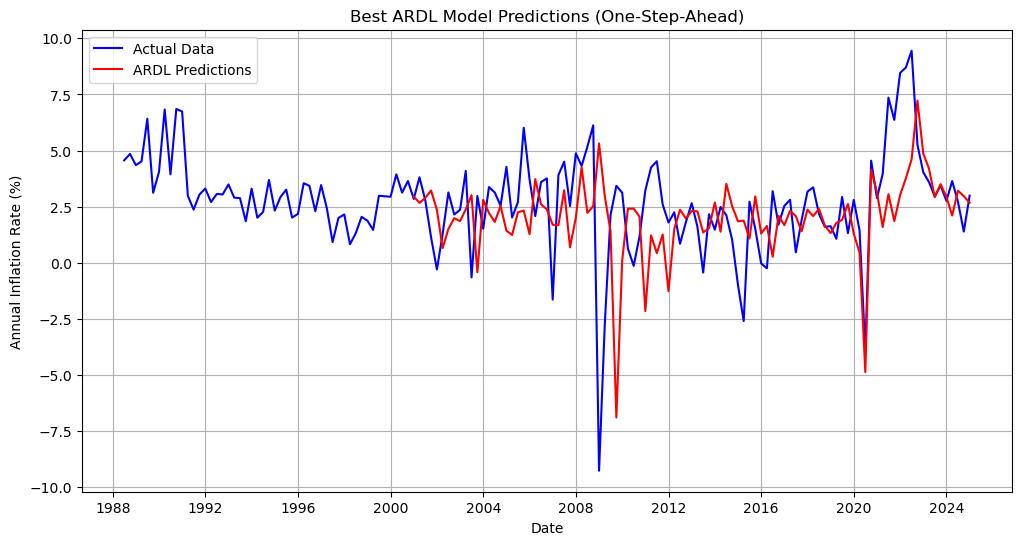

In [470]:
# Plot the corrected predictions
plt.figure(figsize=(12, 6))
plt.plot(df_merged.index, df_merged['Annual Inflation Rate'], label='Actual Data', color='blue')
plt.plot(rolling_predictions_ardl.index, rolling_predictions_ardl, label='ARDL Predictions', color='red')
plt.title('Best ARDL Model Predictions (One-Step-Ahead)')
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()
